# Exploring Meta-T Tetris data from Lindstedt and Gray (2015; 2019)
-------

### Notes on data 

- Download @ https://osf.io/78ebg/
- Three files:
    - "eps" describes the games of 241 participants at the episodic level (behavioural data and scores at each zoid)
    - "gms" provides summary stats (e.g., score, zoid sequence) for each game played in "eps"
    - "quals" includes episodic and summary data for tournament qualifier games played by 44 participants
- All variables described in 2017 paper by Sibert, Lindstedt, and Gray; doi number 10.1111/tops.12225
    - 85 columns in "eps"
    - 15 columns in "gms"
    - 89 columns in "quals"

Import libraries

In [1]:
import os
import sys
import socket
import pingouin as pg
import scipy.stats as scipy

from modules import *
from hmmlearn import hmm

# initialise selected visualisation parameters
sns_styleset()
np.set_printoptions(suppress=True)

/home/ozvar/.local/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Import data

In [2]:
df = pd.read_csv(os.path.join('data', 'pca_eps.csv'), header=0, sep=',', low_memory=False)

In [3]:
df.head()

,ts,event_type,SID,ECID,session,game_type,game_number,episode_number,level,score,lines_cleared,curr_zoid,next_zoid,danger_mode,rots,trans,path_length,min_rots,min_trans,min_path,min_rots_diff,min_trans_diff,min_path_diff,u_drops,s_drops,prop_u_drops,initial_lat,drop_lat,avg_lat,tetrises_game,tetrises_level,zoid_rot,zoid_col,zoid_row,all_diffs,all_ht,all_trans,cd_1,cd_2,cd_3,cd_4,cd_5,cd_6,cd_7,cd_8,cd_9,cleared,col_trans,column_9,cuml_cleared,cuml_eroded,cuml_wells,d_all_ht,d_max_ht,d_mean_ht,d_pits,deep_wells,eroded_cells,full_cells,jaggedness,landing_height,lumped_pits,matches,max_diffs,max_ht,max_ht_diff,max_well,mean_ht,mean_pit_depth,min_ht,min_ht_diff,move_score,nine_filled,pattern_div,pit_depth,pit_rows,pits,row_trans,tetris,tetris_progress,weighted_cells,wells,criterion,crit_game,study,ep_dur,resp_lat,disarray,well_prep,action_inefficiency,dec_act_latency
0,78.4979,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,0,0,16,0,O,S,False,0,4,4,0,4,4,0,0,0,17,2,0.8947,724,2083,416.6000,0,0,0,0,2,-2,4,4,0,-2,0,0,0,0,0,0,0,0,2,0,0,0,0,4,2,0.4000,0,0,0,4,2,0,0,4,0,2,1.6000,0,0.4000,0.0000,0,0.4000,0,0,2,0,0,0,2,0,0,6,0,6042,True,TS1,NaN,2083,-5.1342,-1.5870,-0.6442,1.6669
1,88.2783,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,1,0,24,0,S,O,False,1,7,8,1,3,4,0,4,4,8,10,0.4444,606,4671,505.5455,0,0,1,1,4,-2,9,10,2,-1,-3,0,0,0,0,0,0,0,4,0,0,0,3,5,2,0.5000,1,2,0,8,6,1,1,2,2,4,3.1000,2,0.9000,2.0000,0,0.9000,0,0,4,2,1,1,6,0,0,18,2,6042,True,TS1,9.7805,4671,-3.5601,0.0251,2.0612,1.9656
2,92.9668,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,2,0,38,0,O,J,False,0,10,10,0,4,4,0,6,6,15,4,0.7895,701,4061,369.1818,0,0,0,8,2,0,13,14,2,-1,-3,0,0,0,0,2,0,0,6,2,0,0,3,4,0,0.4000,0,2,0,12,8,0,1,4,2,4,2.7000,2,1.3000,2.0000,0,1.3000,0,0,5,2,1,1,8,0,0,24,2,6042,True,TS1,4.6885,4061,-3.6737,-0.0469,1.5389,-0.1266
3,99.3719,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,3,0,51,0,J,S,False,1,4,5,1,1,2,0,3,3,13,6,0.6842,902,2089,621.0000,0,0,1,2,3,0,16,14,2,-1,0,-3,0,0,0,2,0,0,6,2,0,0,3,3,0,0.3000,-1,2,0,16,8,0,0,6,2,4,2.4000,2,1.6000,0.0000,0,1.6000,0,0,6,0,0,0,8,0,0,31,2,6042,True,TS1,6.4051,2089,-3.6946,-0.0795,-0.0081,0.3828
4,106.9975,EP_SUMM,101,NIL,2013_6_6_12-23-50,pop_assessment,1,4,0,58,0,S,O,False,3,3,6,1,3,4,2,0,2,8,8,0.5000,857,6591,820.8889,0,0,1,1,6,0,20,18,4,-1,-2,-3,0,0,0,2,0,0,6,2,0,0,10,4,2,0.4000,0,4,0,20,12,3,0,3,4,6,4.0000,4,2.0000,0.0000,0,2.0000,0,0,6,0,0,0,12,0,0,51,4,6042,True,TS1,7.6256,6591,-2.5802,1.9508,2.4554,2.7202


## Hidden Markov Models

Set up parameters here
- declare number of states we expect to see
- declare factors to include in the model
- choose player and game to fit model to

In [4]:
# model
n_states = 3
factors = ['disarray', 'well_prep', 'action_inefficiency', 'dec_act_latency']
# data 
player_id = '103'
nth_game = 3
# for plot legends
factor_labels = {'disarray': 'Disarray', 
                'well_prep': 'Well preparation',
                'action_inefficiency': 'Action inefficiency',
                'dec_act_latency': 'Decision-action latency'}

Generate model from above parameters, returning transition matrix and log-likelihood

In [5]:
model, post_prob, LL = fit_HMM(df=df,
                               n_states=n_states, 
                               factors=factors,
                               factor_labels=factor_labels,
                               player_id=player_id,
                               nth_game=nth_game,
                               n_iter=1000,
                               covar_type='full')

Fitting 3 state model to game 3 of player 103
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.9400   0.0000   0.0600
State 2   0.0000   1.0000   0.0000
State 3   0.1500   0.0500   0.8000 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Disarray                 -2.4049   4.8032   0.1927
Well preparation         -0.0351  -1.4111   1.4551
Action inefficiency      -0.9543  -0.7751   0.4624
Decision-action latency  -0.1930  -0.4477   0.3492 

Log-likelihood of model is -754.59


Visualise time series of state probabilities together with component scores

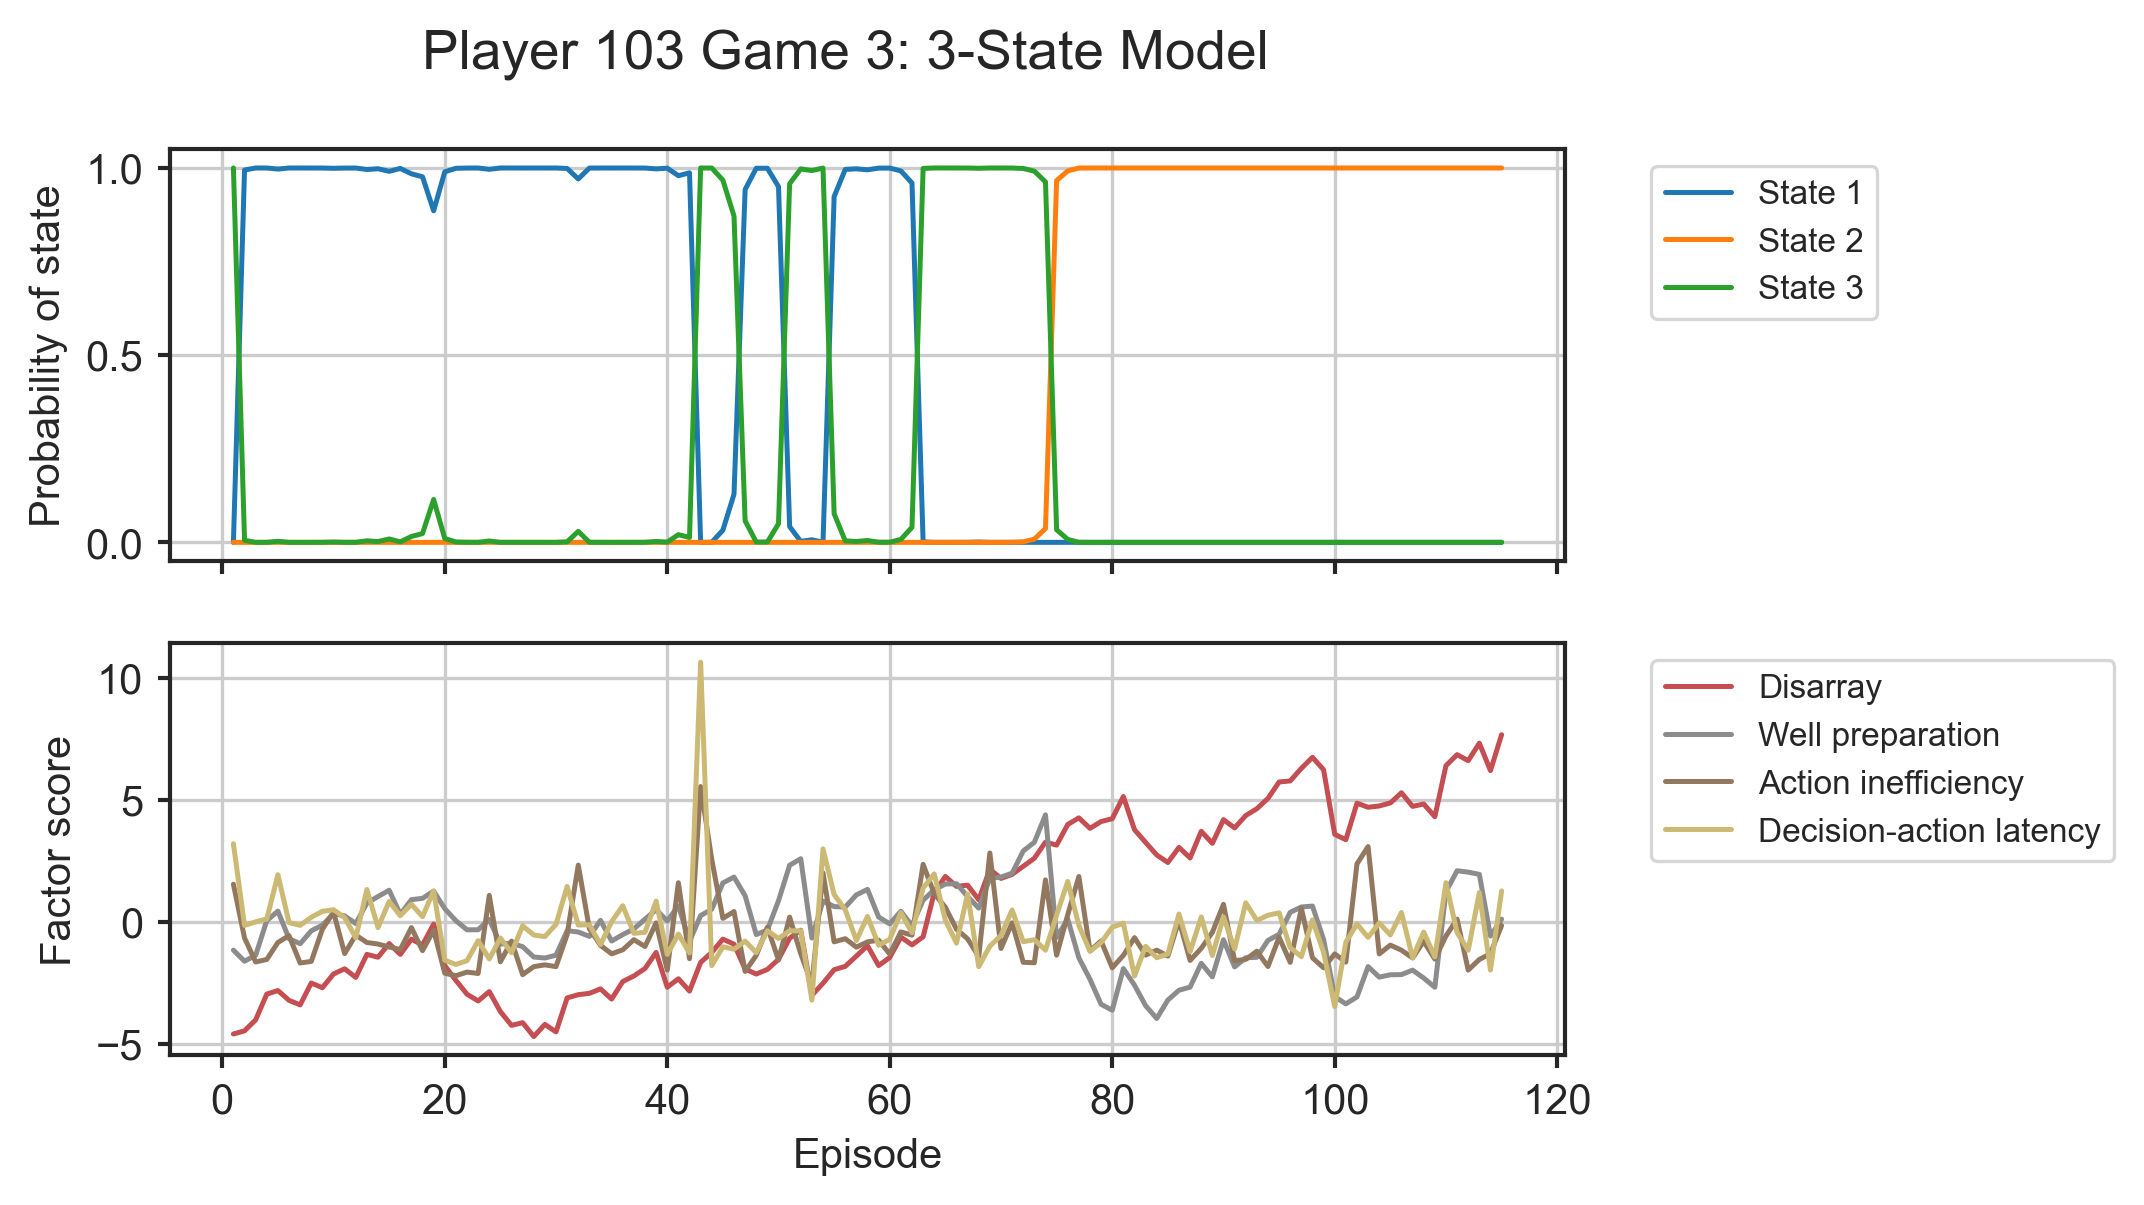

In [6]:
viz_states(df=df, 
           n_states=n_states,
           factors=factors,
           factor_labels=factor_labels,
           post_prob=post_prob,
           player_id=player_id, 
           nth_game=nth_game)

### Visualising multiple HMMs

This block first draws a subsample of tetris games played be the specified players. It then creates containers to store models for each of those games.

In [7]:
# randomly draw from our player sample
players =  ['102']
n_draw = 1
draw = np.random.choice(players, n_draw, replace=False)

# specify number of games for each player
n_games = 5

# specify number of states to iterate over
n_states = [3]

# specify factors and containers
factors = ['well_prep', 'action_inefficiency', 'dec_act_latency']

models, post_probs, LLs = [], [], []
null_models, null_probs, null_LLs = [], [], []
counter = 1

# path to save figures
fig_dir = os.path.join('figures', 'HMMs')

This block iterates over each game, fitting, saving, and visualising HMMs to each game as above, as well as a "null" model consisting of random series for each component

---
MODEL 1: Player 102 Game 1
---
Fitting 3 state model to game 1 of player 102
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.1200   0.1100   0.7700
State 2   0.1200   0.8700   0.0100
State 3   0.1000   0.0300   0.8700 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation         -0.6450   1.3251  -1.2197
Action inefficiency       4.6694   0.3302  -0.2338
Decision-action latency  -2.2068  -0.1653  -0.3621 

Log-likelihood of model is -727.29
---
NULL MODEL 1: Player 102 Game 1 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.6200   0.0600   0.3200
State 2   0.6400   0.0900   0.2700
State 3   0.5700   0.1600   0.2600 

---------------------------
Component means for each state:
-------------------------

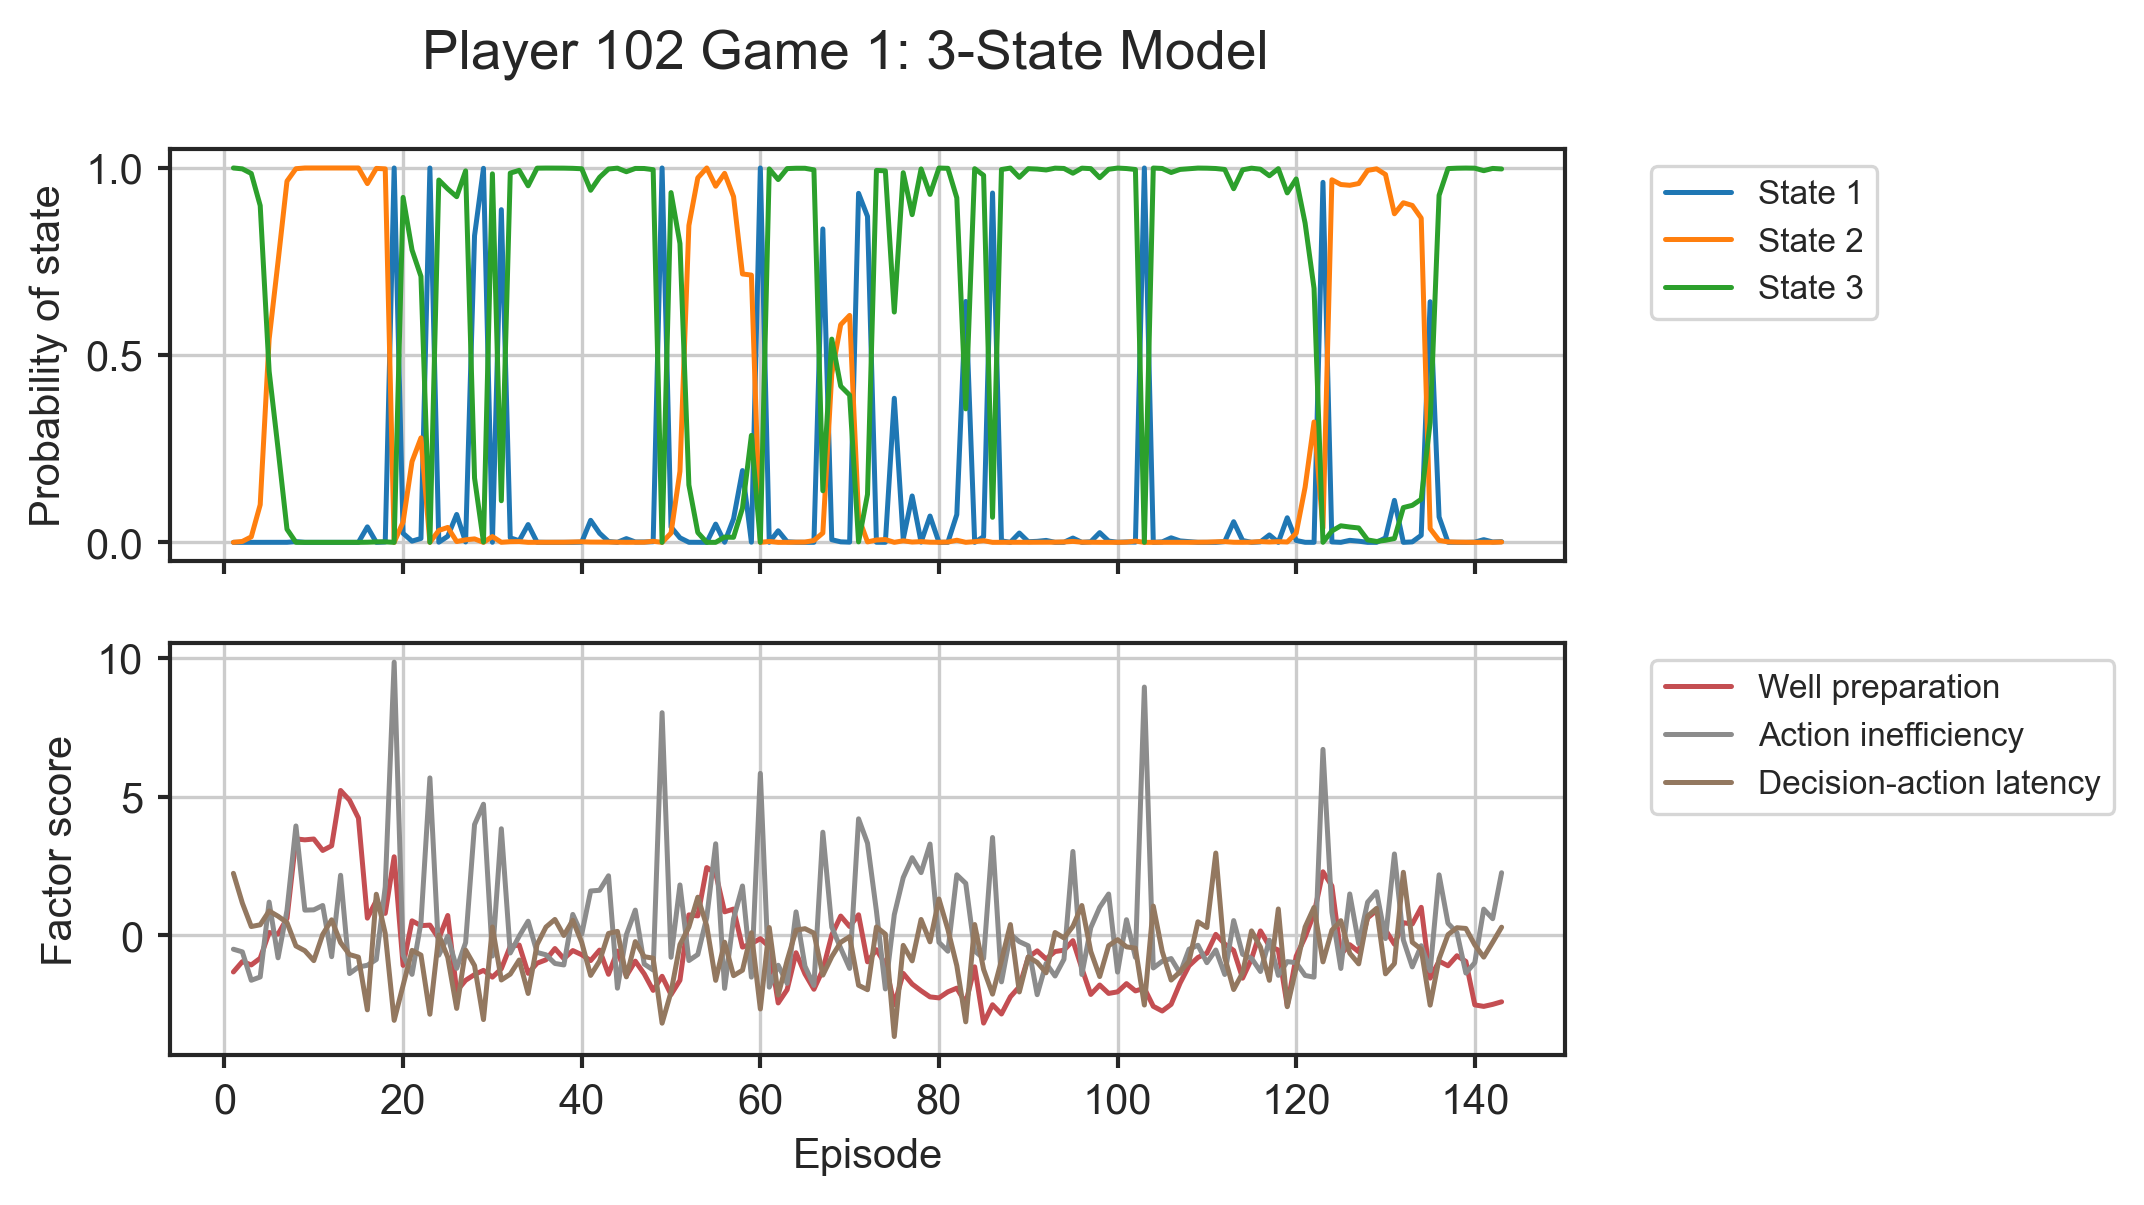

---
MODEL 2: Player 102 Game 2
---
Fitting 3 state model to game 2 of player 102
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.7000   0.2800   0.0200
State 2   0.7900   0.1800   0.0400
State 3   0.0600   0.1000   0.8400 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation         -0.3027  -0.2152  -2.3148
Action inefficiency      -0.3578   3.5072  -0.0588
Decision-action latency  -0.2181  -1.7396   0.2188 

Log-likelihood of model is -807.34
---
NULL MODEL 2: Player 102 Game 2 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.2400   0.5100   0.2500
State 2   0.7100   0.2500   0.0400
State 3   0.1500   0.5600   0.2900 

---------------------------
Component means for each state:
-------------------------

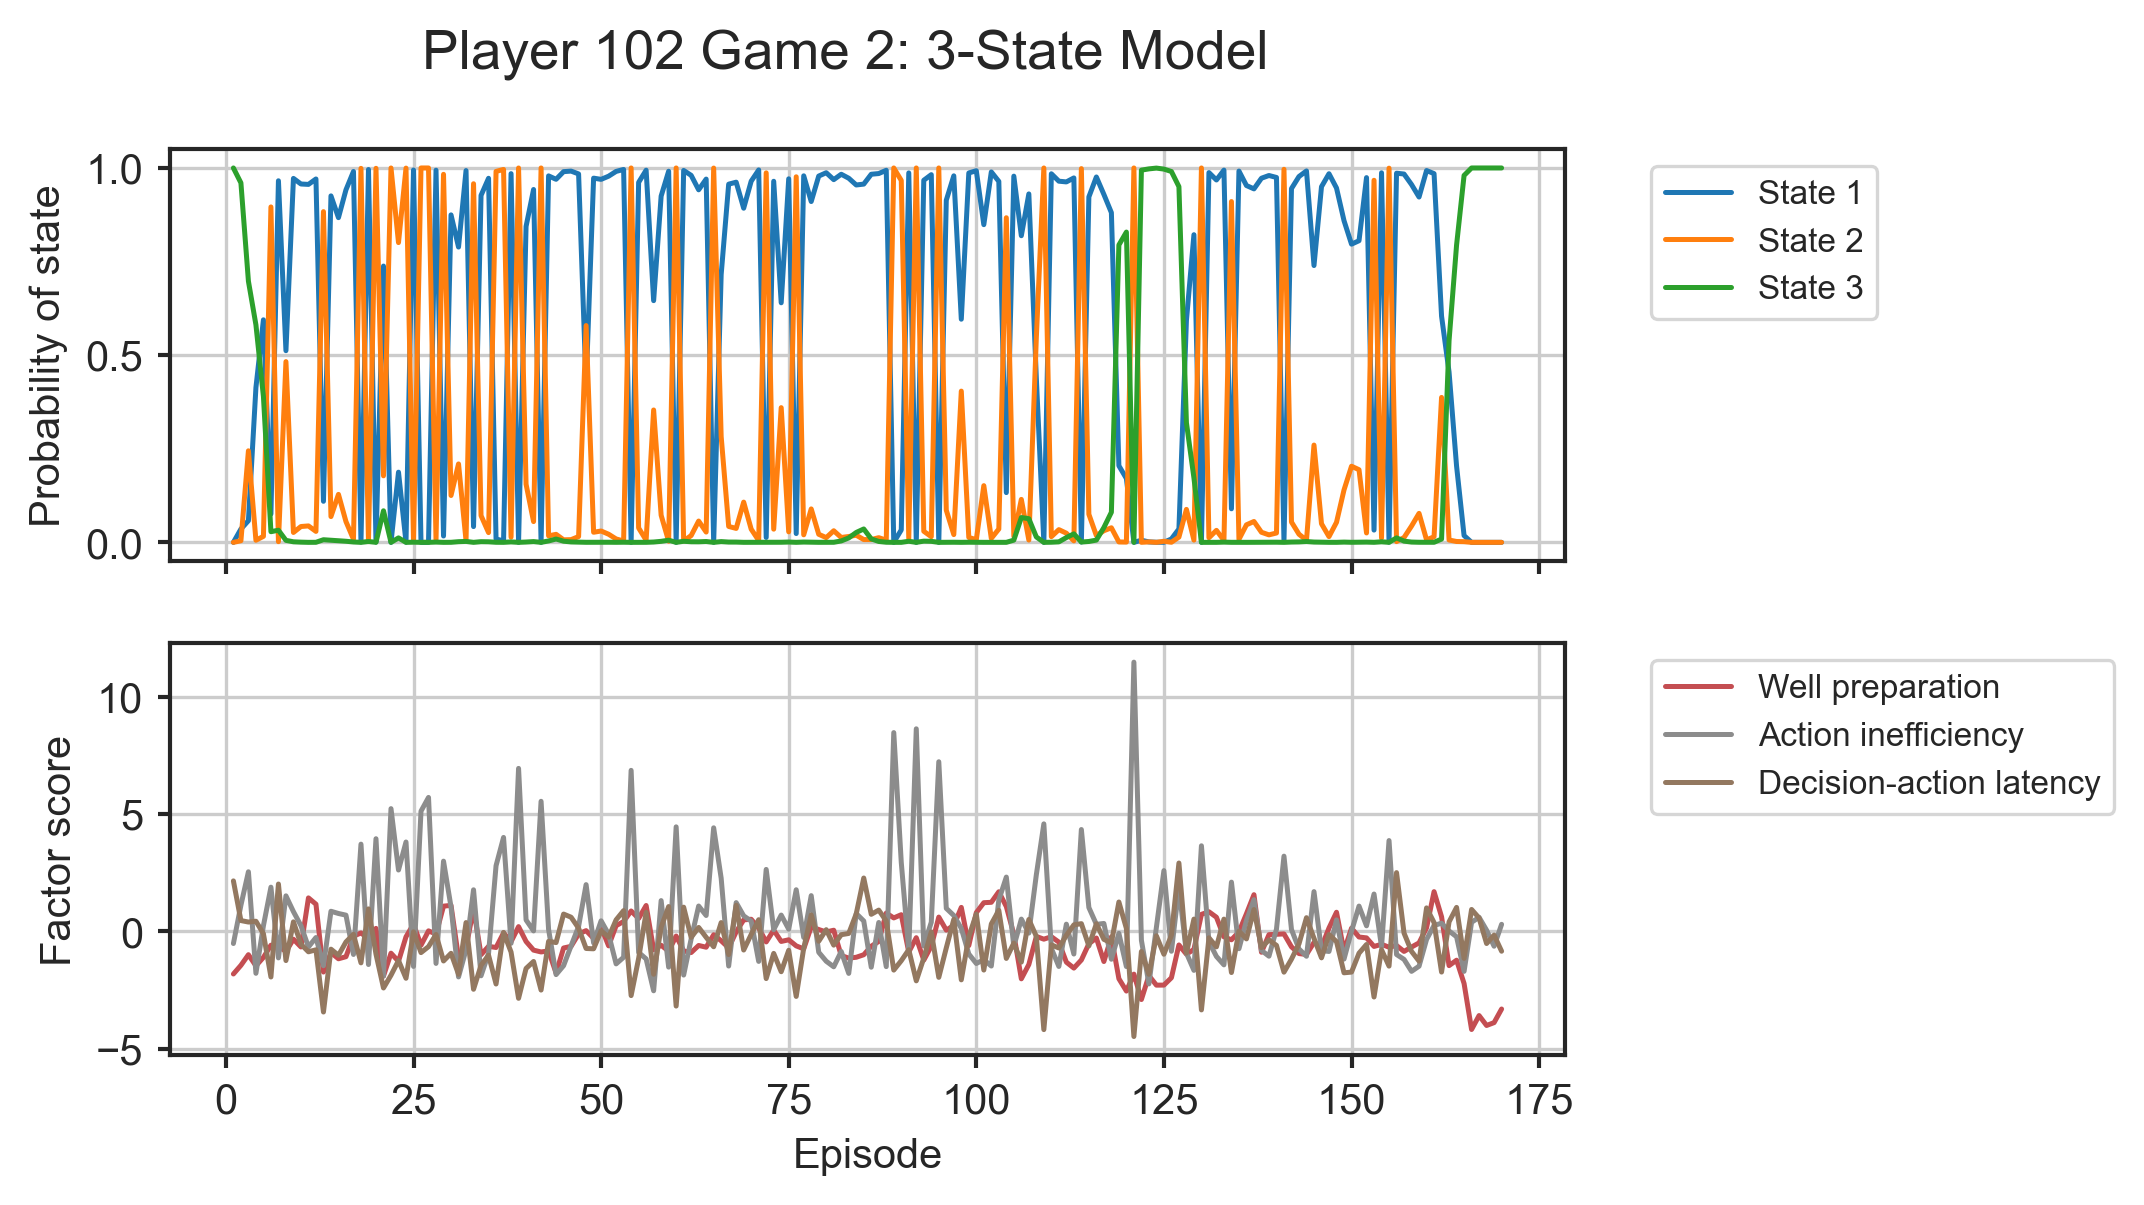

---
MODEL 3: Player 102 Game 3
---
Fitting 3 state model to game 3 of player 102
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.9200   0.0000   0.0800
State 2   0.0000   0.7900   0.2100
State 3   0.0700   0.8400   0.0900 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation          2.7690  -1.4693  -0.8095
Action inefficiency       0.0044  -0.4432   3.2553
Decision-action latency   0.0761  -0.2356  -1.8237 

Log-likelihood of model is -788.03
---
NULL MODEL 3: Player 102 Game 3 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.1800   0.5600   0.2600
State 2   0.1000   0.6400   0.2600
State 3   0.1700   0.5600   0.2800 

---------------------------
Component means for each state:
-------------------------

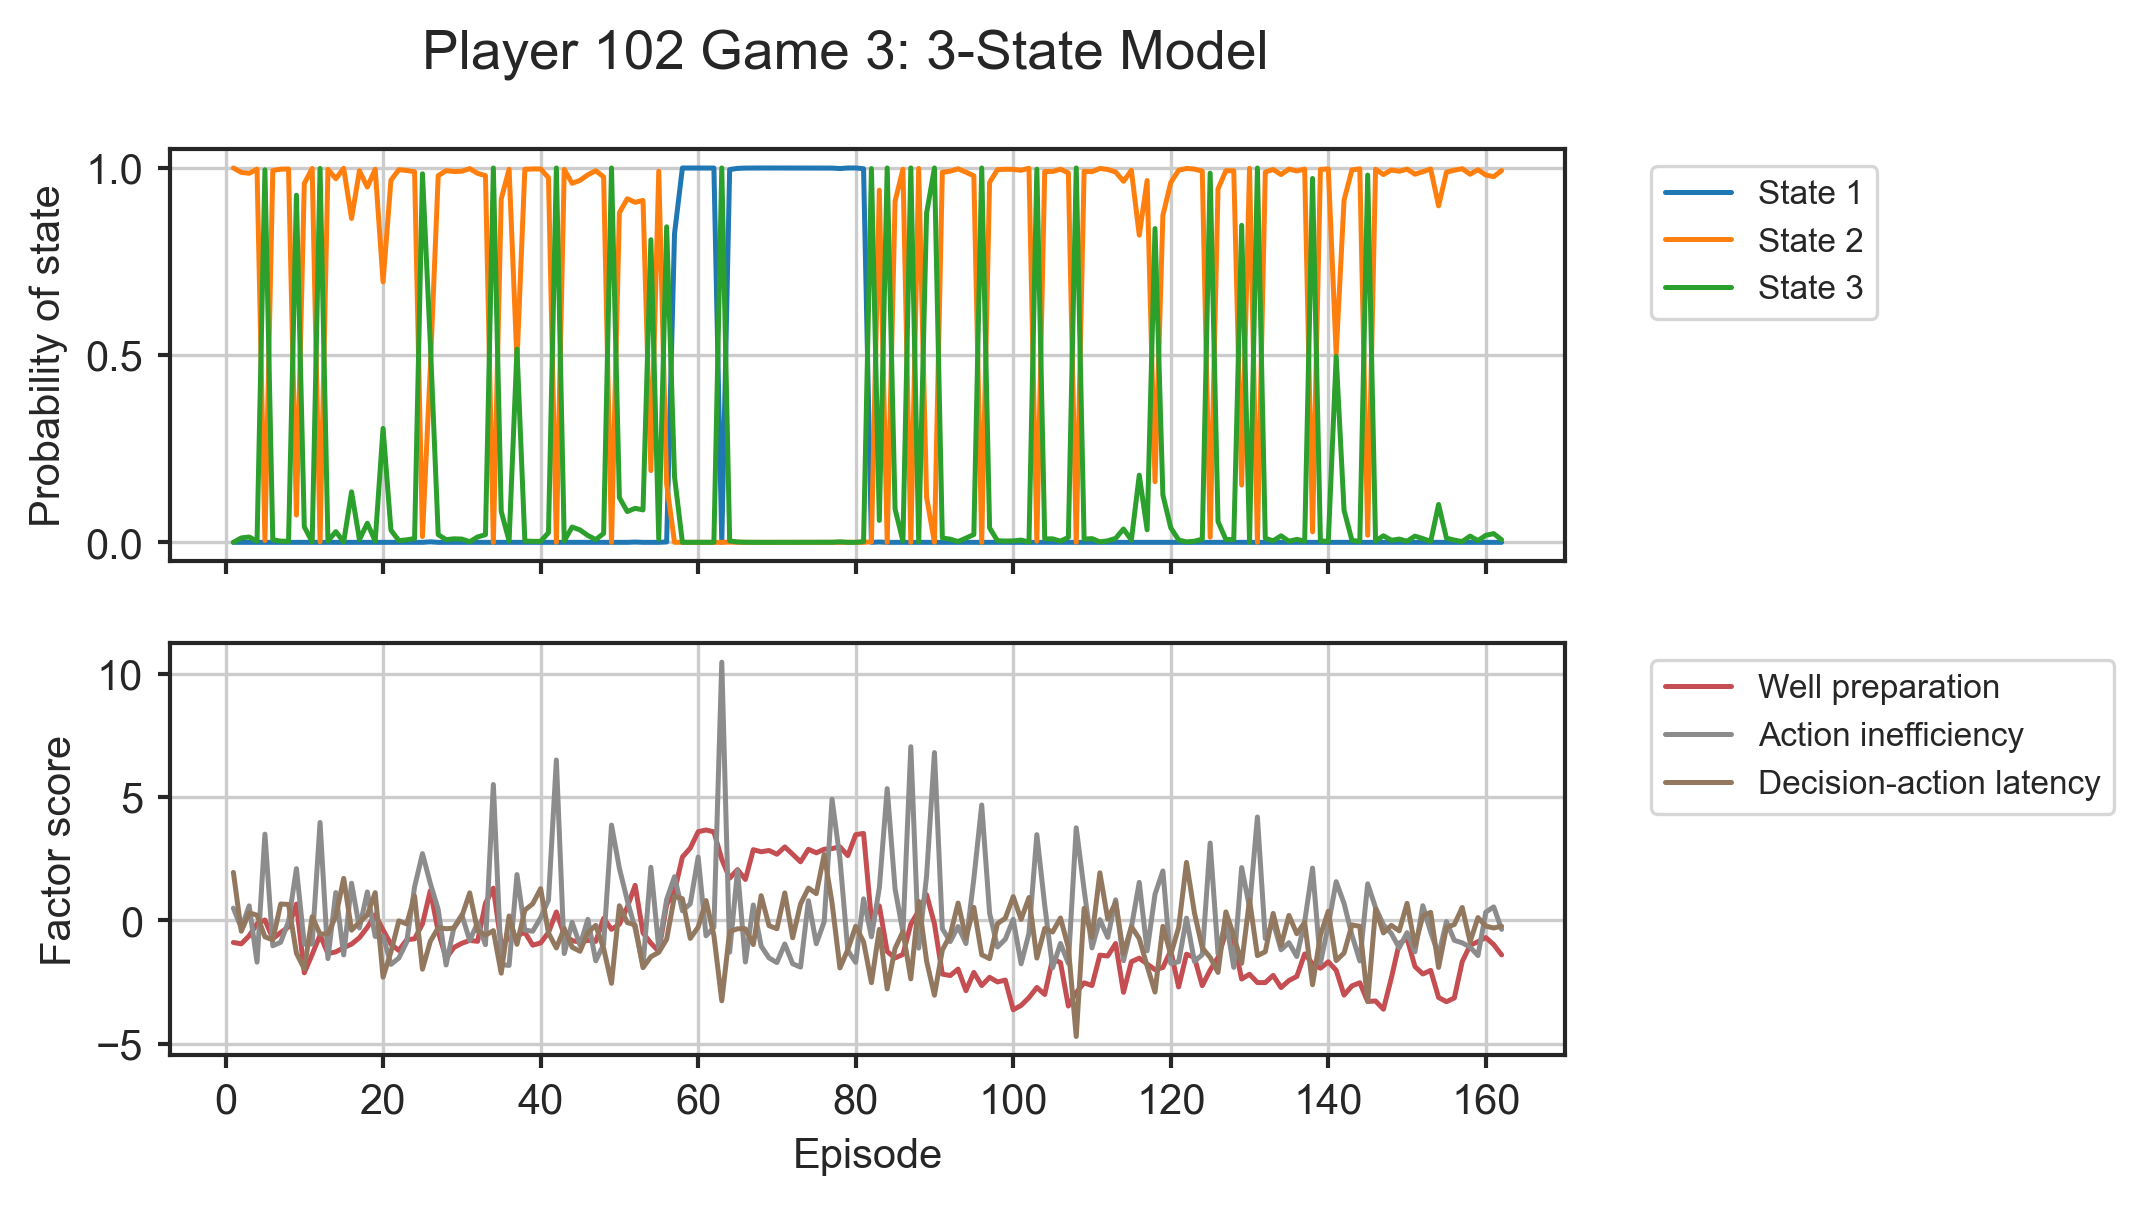

---
MODEL 4: Player 102 Game 4
---
Fitting 3 state model to game 4 of player 102
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.0600   0.2000   0.7400
State 2   0.0800   0.8900   0.0300
State 3   0.2200   0.0000   0.7800 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation          1.7612  -2.6221   1.5281
Action inefficiency       6.1417  -0.2075  -0.0261
Decision-action latency  -2.3227  -0.1126  -0.5238 

Log-likelihood of model is -970.59
---
NULL MODEL 4: Player 102 Game 4 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.1600   0.2000   0.6500
State 2   0.4400   0.4600   0.1000
State 3   0.2500   0.2800   0.4700 

---------------------------
Component means for each state:
-------------------------

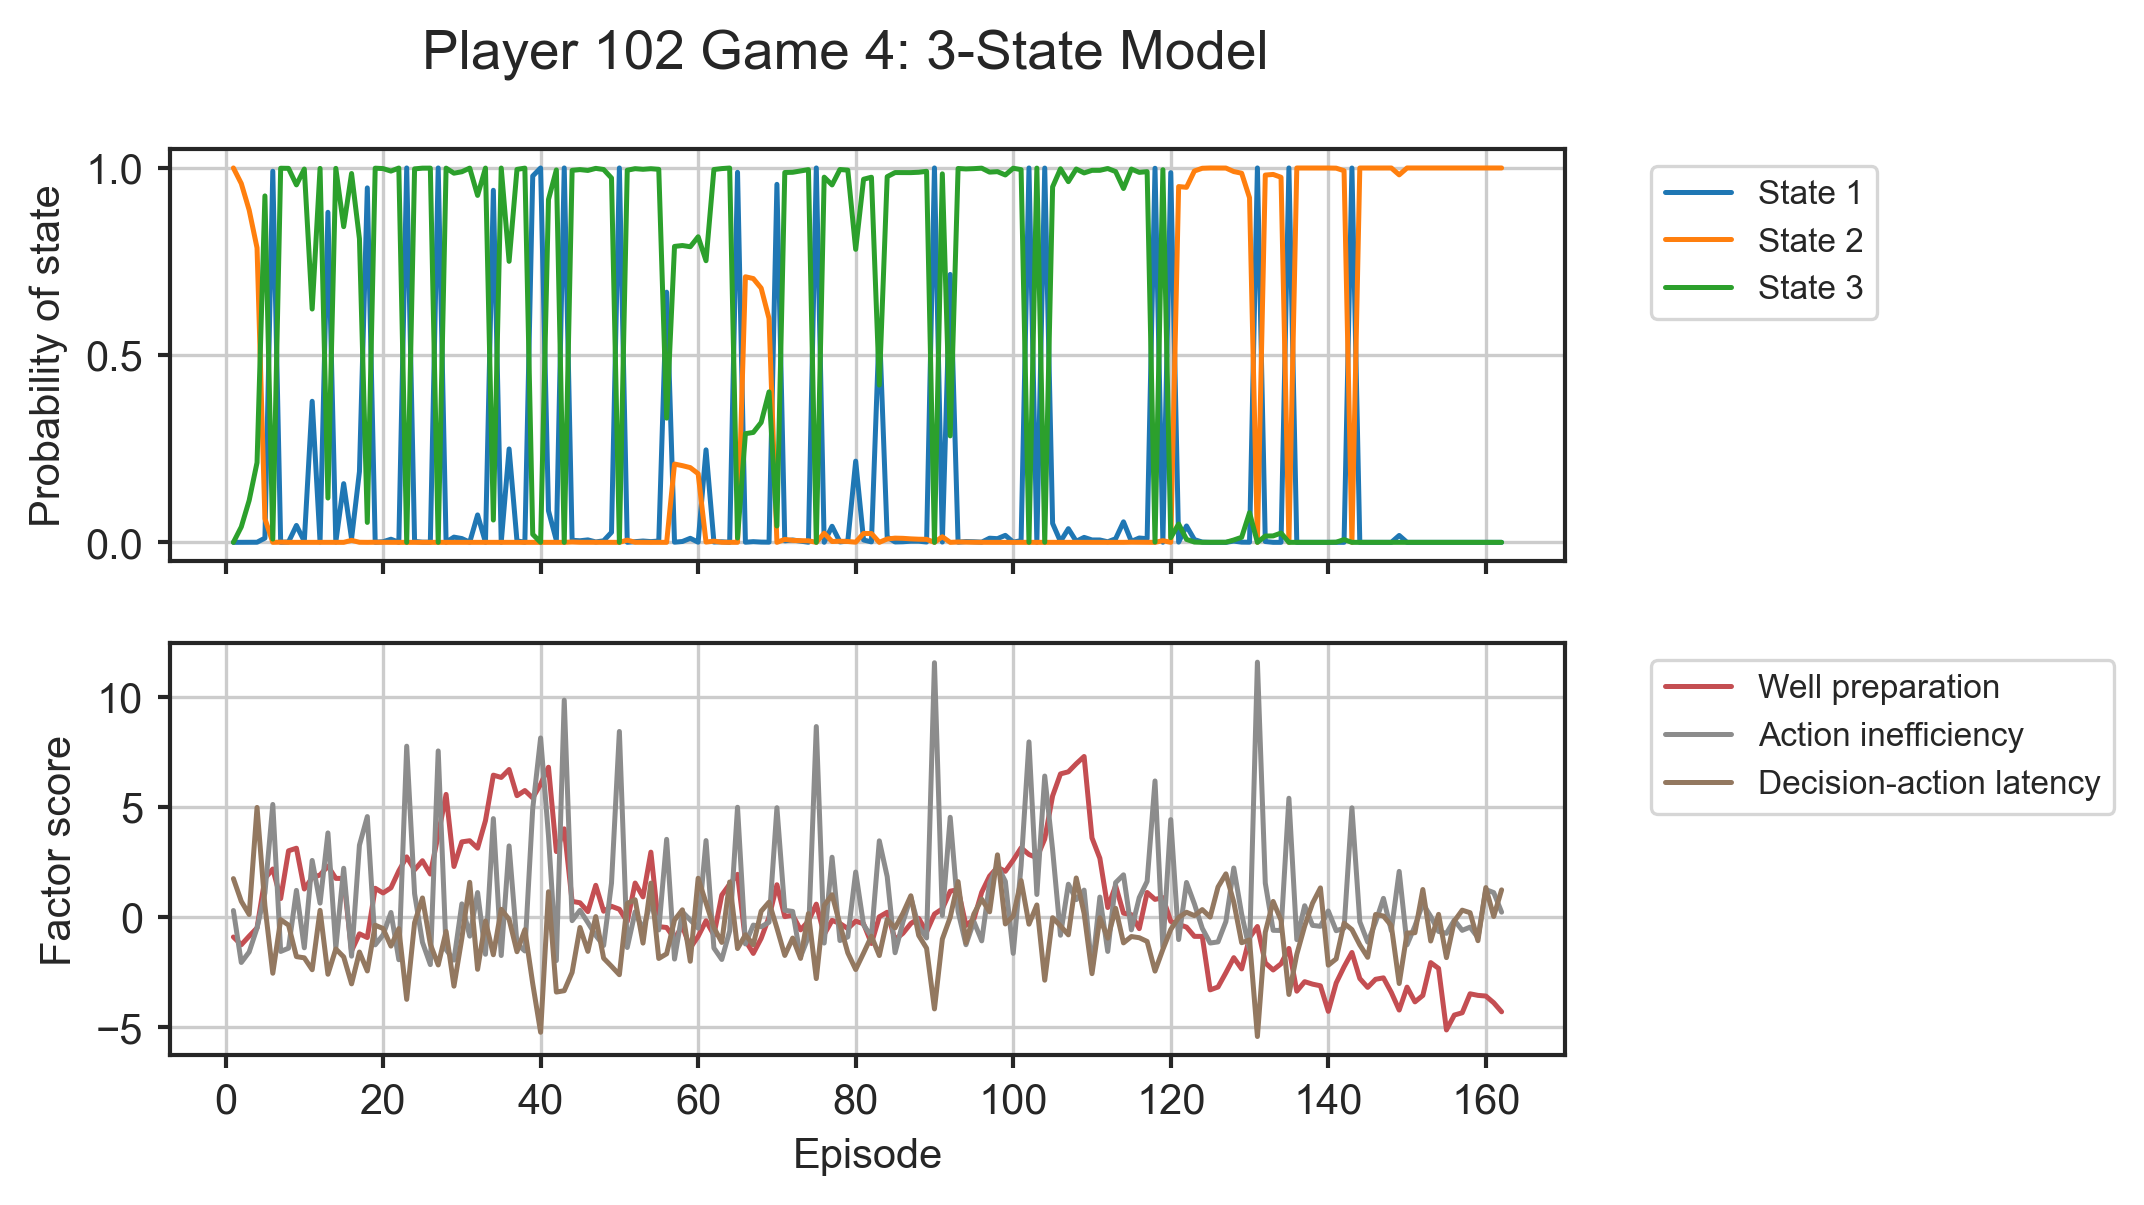

---
MODEL 5: Player 102 Game 5
---
Fitting 3 state model to game 5 of player 102
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.9600   0.0000   0.0400
State 2   0.0000   0.0000   1.0000
State 3   0.0500   0.1000   0.8500 

---------------------------
Component means for each state:
---------------------------

                         State 1  State 2  State 3
Well preparation         -0.5343   5.1620   4.4770
Action inefficiency       0.3326   7.7263   0.4066
Decision-action latency  -0.3794  -4.2242  -0.3089 

Log-likelihood of model is -274.73
---
NULL MODEL 5: Player 102 Game 5 (shuffled data)
---
---------------------------
Transition probabilities:
---------------------------
         State 1  State 2  State 3
State 1   0.5000   0.4300   0.0600
State 2   0.0000   0.3900   0.6000
State 3   1.0000   0.0000   0.0000 

---------------------------
Component means for each state:
-------------------------

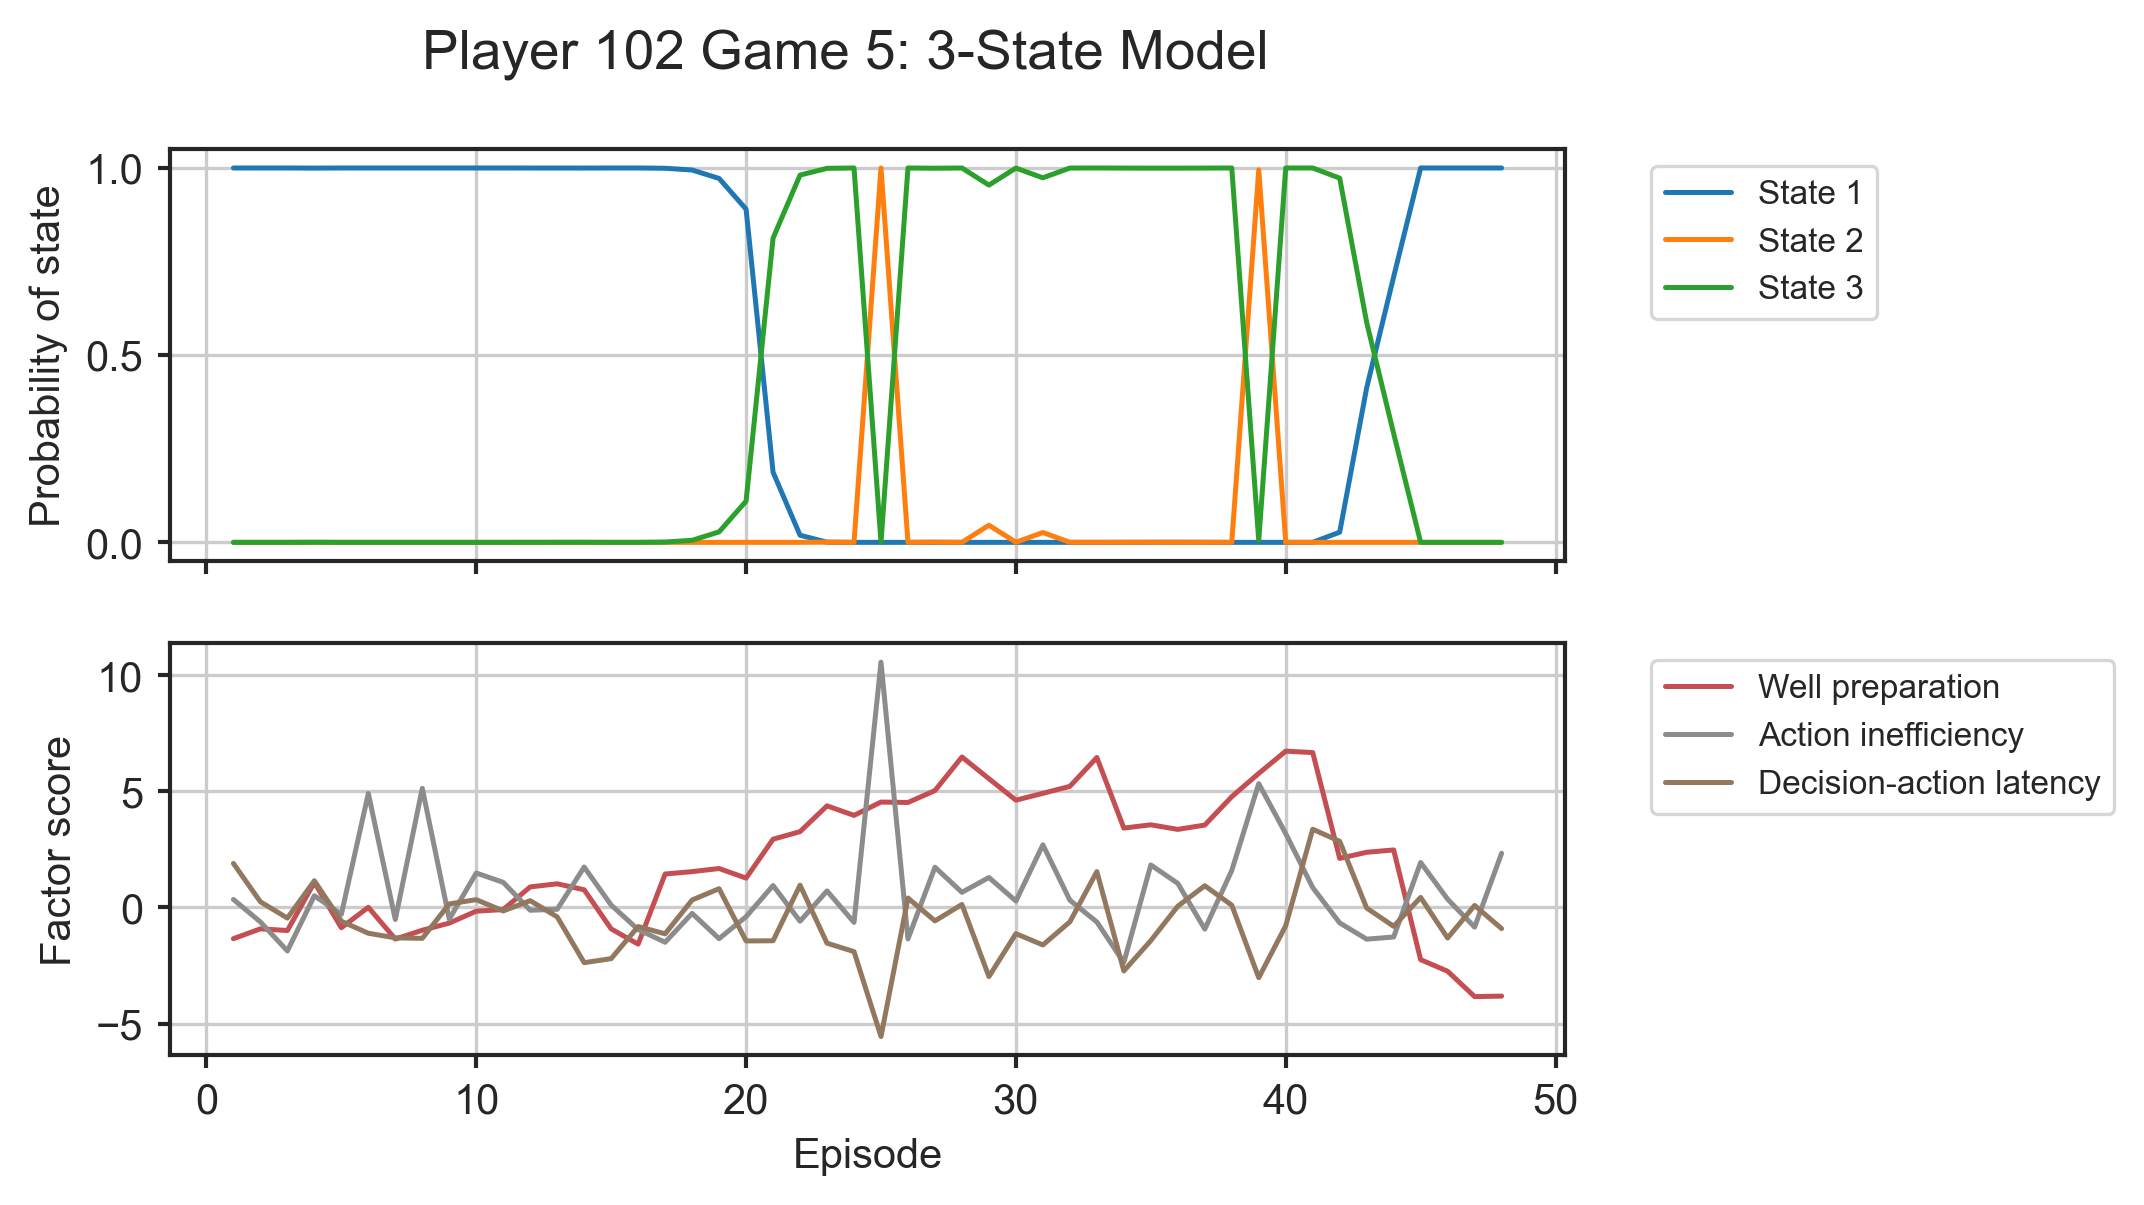

In [8]:
# iterate over subsample
for player in draw:
    for game in range(1, n_games+1):
        for n in n_states:
            print(f'---\nMODEL {counter}: Player {player} Game {game}\n---')
            # fit HMM
            model, post_prob, LL = fit_HMM(df=df,
                                        n_states=n, 
                                        factors=factors, 
                                        factor_labels=factor_labels, 
                                        player_id=player,
                                        nth_game=game,
                                        n_iter=1000,
                                        covar_type='diag')
            models.append(model)
            post_probs.append(post_prob)
            LLs.append(LL)
            # fit HMM after shuffling data in each array - this is our null model for comparison
            print(f'---\nNULL MODEL {counter}: Player {player} Game {game} (shuffled data)\n---')
            null_model, null_prob, null_LL = fit_HMM(df=df,
                            n_states=n, 
                            factors=factors, 
                            factor_labels=factor_labels, 
                            player_id=player,
                            nth_game=game,
                            n_iter=1000,
                            covar_type='diag',
                            null_model=True)
            null_models.append(null_model)
            null_probs.append(null_prob)
            null_LLs.append(null_LL)
            # visualise data
            viz_states(df=df, 
                       n_states=n,
                       factors=factors,
                       factor_labels=factor_labels,
                       post_prob=post_prob,
                       player_id=player, 
                       nth_game=game,
                       fig_dir=fig_dir)
            counter += 1

## Match states across models

- States can switch labels every time a model is fitted to new data - i.e. a state 1 determined principally by action inefficiency might be labelled as state 3 in a different game.
- We attempt to match states here by correlating the vector of component means for each state between models (2 models at a time).
- Two states are "matched" if their correlation is above a specified threshold.
- If each state in model A has one unique match in model B, the matching is successful and we can claim the existence of some unique states co-existing in models A and B.
- If the unique matching is successful between every pair of models for a given player, we can further claim the existence of some unique internal states associated with performance for this player's tetris experience.

In [9]:
n_states = 3
a = models[1].means_
b = models[2].means_

corr_mat = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        corr = scipy.pearsonr(a[i], b[j])[0]
        corr_mat[i, j] = corr

In [10]:
corr_mat

array([[-0.09905909,  0.27609382, -0.89792692],
       [-0.25713426,  0.07946595,  0.99534919],
       [-0.99246914,  0.99833568,  0.23161207]])

In [11]:
n = 3
threshold = 0.8

total = 0
successes = 0 
for index_a, model_a in enumerate(models):
    for index_b, model_b in enumerate(models[index_a+1:]):
        a = model_a.means_
        b = model_b.means_
        corr_mat = cross_corr(n, a, b)
        state_names = [f'State {i+1}' for i in range(n_states)]
        corr_df = pd.DataFrame(corr_mat)
        corr_df.index = corr_df.columns = state_names
        print('---')
        print(f'Correlating state vectors of models {index_a+1} and {index_a+index_b+2}')
        total += 1
        if check_unique_state_matches(n, corr_df, threshold):
            successes += 1

print(f'\nTotal successful matches = {successes} / {total}')

---
Correlating state vectors of models 1 and 2
States failed to match
---
Correlating state vectors of models 1 and 3
Matching states identified
---
Correlating state vectors of models 1 and 4
Matching states identified
---
Correlating state vectors of models 1 and 5
**States failed to match**
---
Correlating state vectors of models 2 and 3
**States failed to match**
---
Correlating state vectors of models 2 and 4
**States failed to match**
---
Correlating state vectors of models 2 and 5
**States failed to match**
---
Correlating state vectors of models 3 and 4
Matching states identified
---
Correlating state vectors of models 3 and 5
**States failed to match**
---
Correlating state vectors of models 4 and 5
States failed to match

Total successful matches = 3 / 10


Work-in-progress blocks identifying and visualising unique matches between any two given models

In [12]:
game_a = 0
game_b = 1

a = models[game_a].means_
b = models[game_b].means_

corr_mat = cross_corr(n, a, b)
state_names = [f'State {i+1}' for i in range(n)]
corr_df = pd.DataFrame(corr_mat)
corr_df.index = corr_df.columns = state_names

In [13]:
print('Model A')
print(tabulate_means(models[game_a], factors, factor_labels, n), '\n')
print('---')
print('Model B')
print(tabulate_means(models[game_b], factors, factor_labels, n), '\n')

Model A
                         State 1  State 2  State 3
Well preparation         -0.6450   1.3251  -1.2197
Action inefficiency       4.6694   0.3302  -0.2338
Decision-action latency  -2.2068  -0.1653  -0.3621 

---
Model B
                         State 1  State 2  State 3
Well preparation         -0.3027  -0.2152  -2.3148
Action inefficiency      -0.3578   3.5072  -0.0588
Decision-action latency  -0.2181  -1.7396   0.2188 



In [14]:
check_unique_state_matches(n, corr_df, threshold)

States failed to match


False

In [15]:
corr_df

,State 1,State 2,State 3
State 1,-0.9101,0.9977,0.2037
State 2,-0.4390,0.0950,-0.9731
State 3,0.0020,0.3497,0.9759


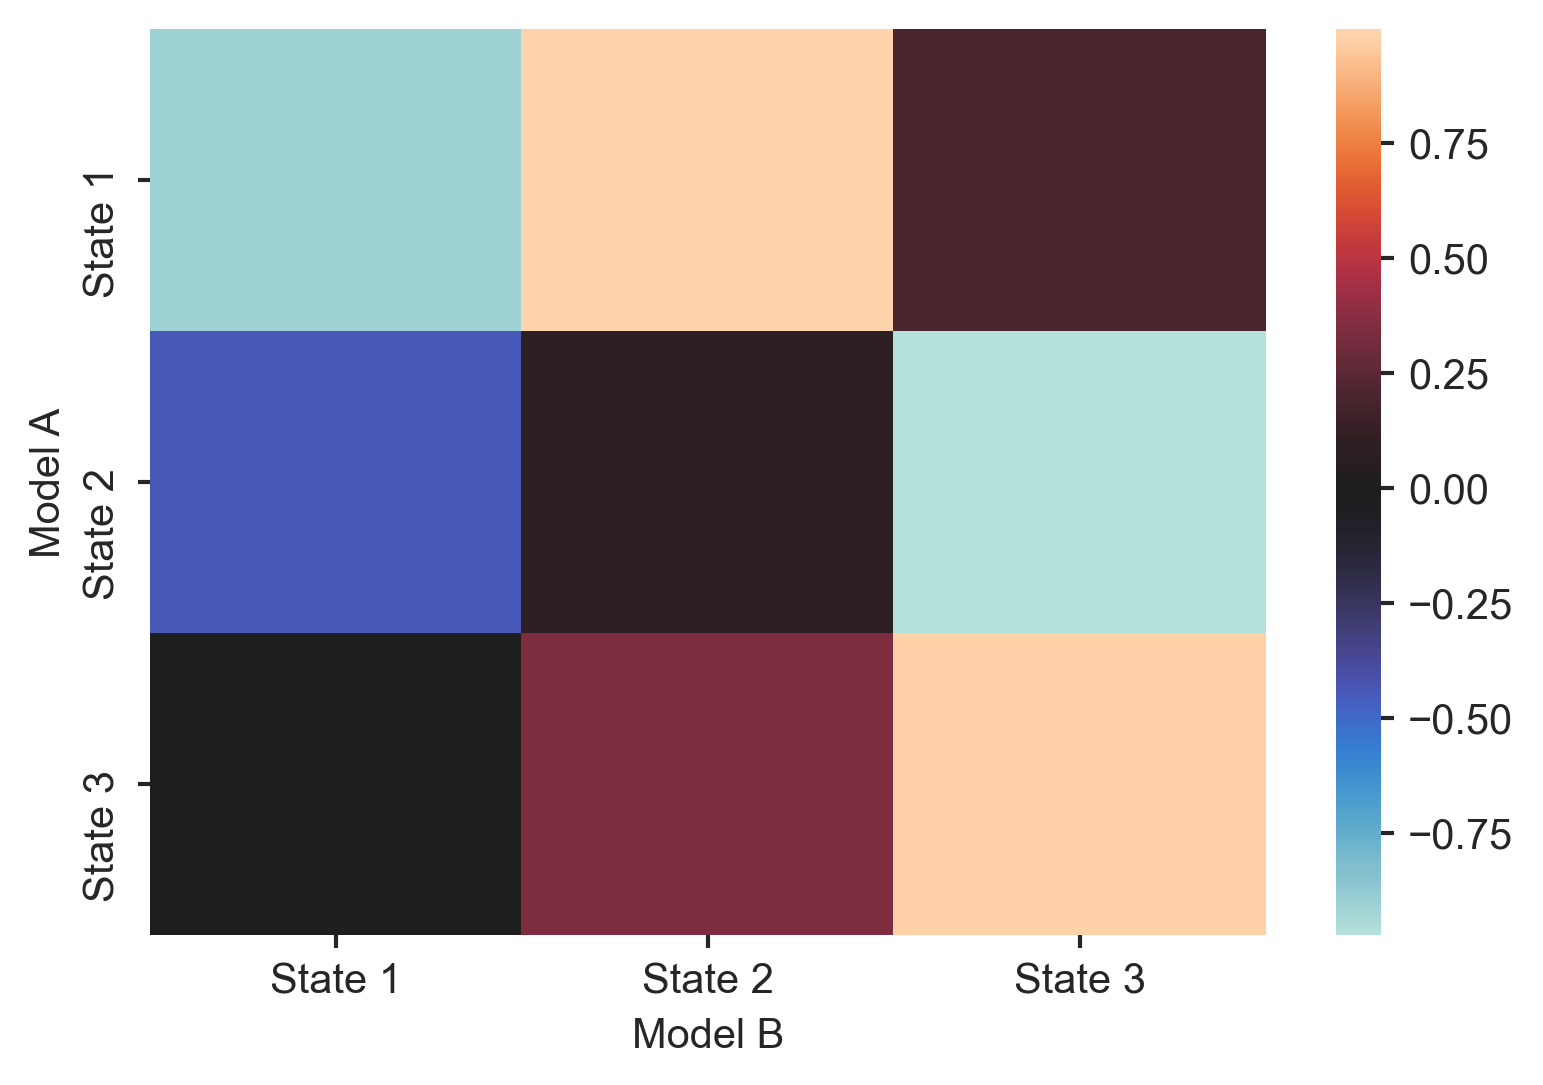

In [16]:
ax = sns.heatmap(corr_df, center=0)
ax.set_ylabel('Model A')
ax.set_xlabel('Model B')

plt.show()

### Visualise state similarities in 2D space using MDS

In [17]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances

Fit HMM to first game of each player and concatenate all vectors of means describing each state

In [39]:
nth_game = 1
players = df['SID'].unique()
states = []
for player_id in players:
    model, post_prob, LL = fit_HMM(df=df,
                                n_states=3, 
                                factors=factors, 
                                factor_labels=factor_labels, 
                                player_id=player,
                                nth_game=game,
                                verbose=False,
                                n_iter=1000,
                                covar_type='diag')
    states.append(model.means_)

states = np.concatenate(states)

Initialise MDS

In [42]:
seed = np.random.RandomState(seed=3)

# sklearn does metric MDS by default, but non-metric MDS is possible using the "metric" boolean
mds = manifold.MDS(
    n_components=2,
    metric=True,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="euclidean",
    n_jobs=1,
)

Feed data states to MDS to visualise similarities

In [43]:
pos2d = mds.fit(states).embedding_
pos2d.shape

(717, 2)

In [45]:
pos2d

array([[ 1.83033398, -2.44093953],
       [-6.20840527, -0.31808003],
       [ 3.54873769,  2.26677196],
       ...,
       [ 3.54878597,  2.26010365],
       [-6.14402889, -0.34484532],
       [ 1.82833141, -2.44618055]])

Histograms of x and y coordinates

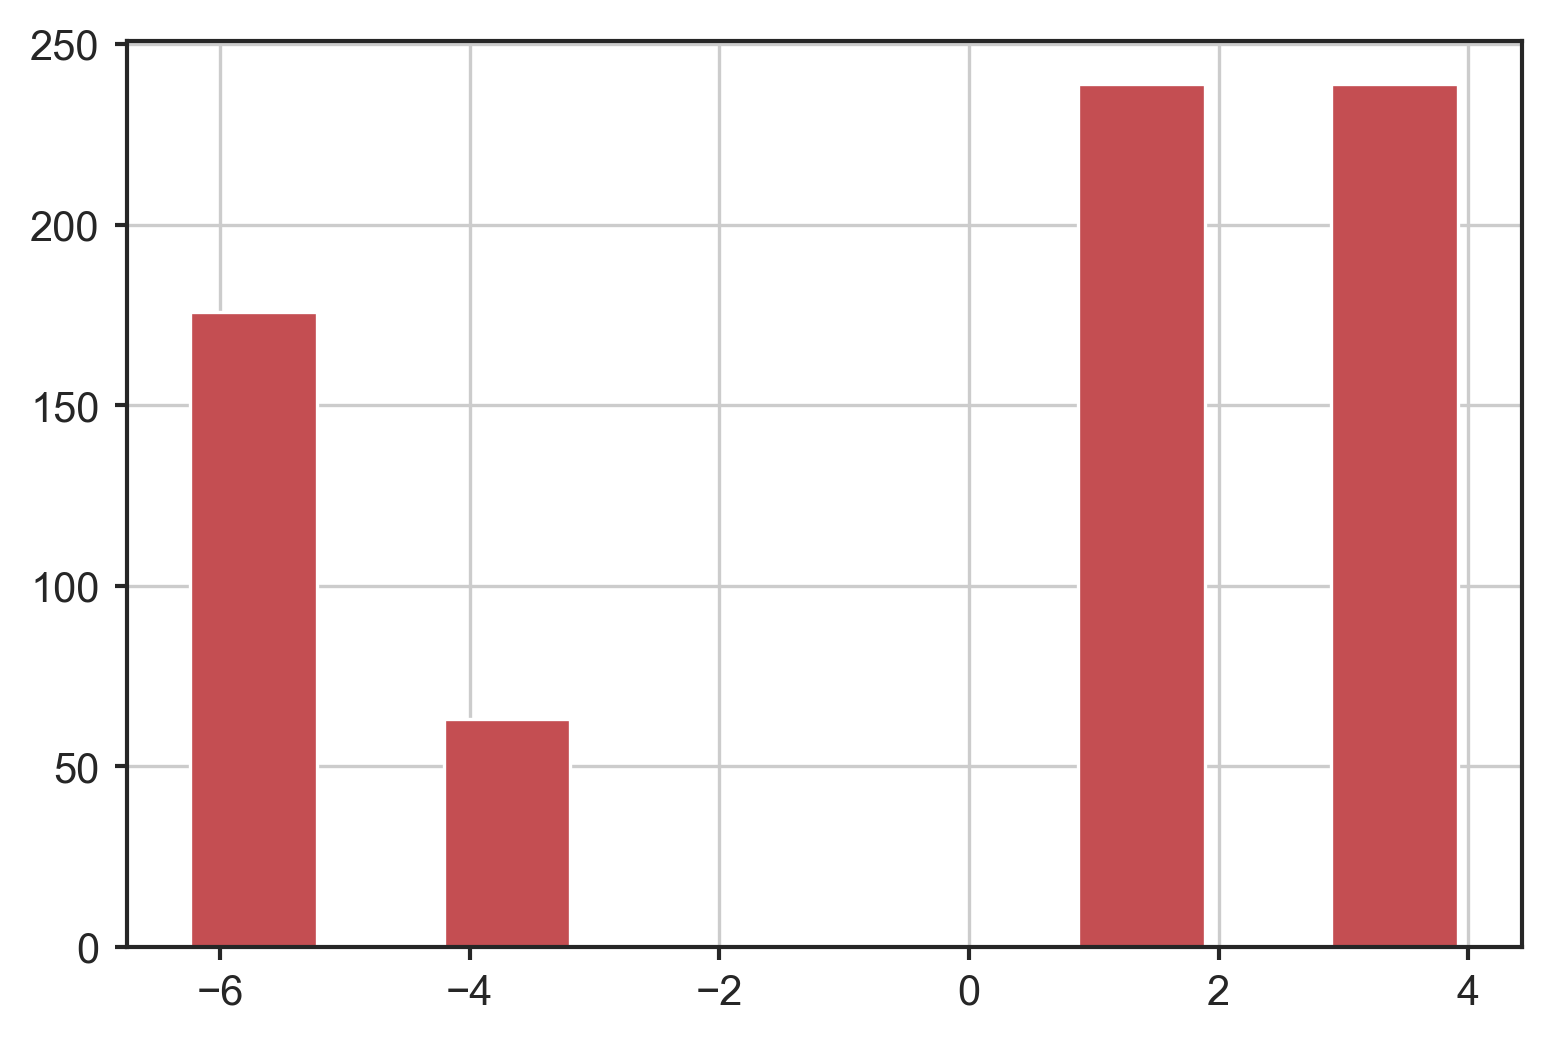

In [47]:
plt.hist(pos2d[:,0])
plt.show()

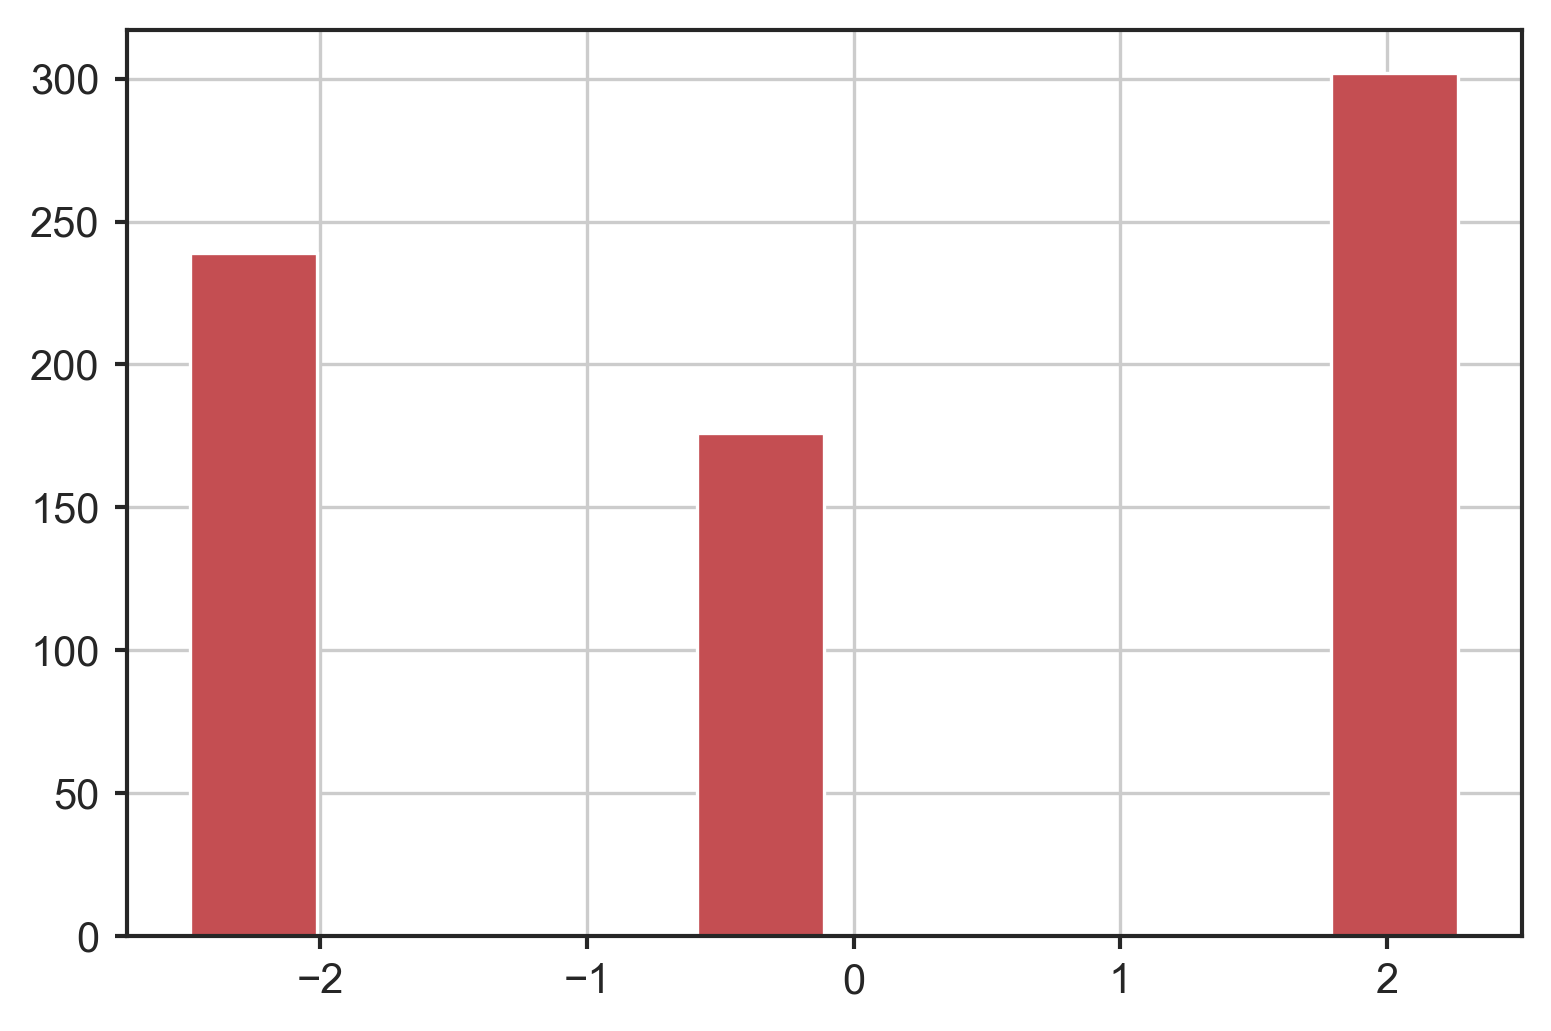

In [49]:
plt.hist(pos2d[:,1])
plt.show()

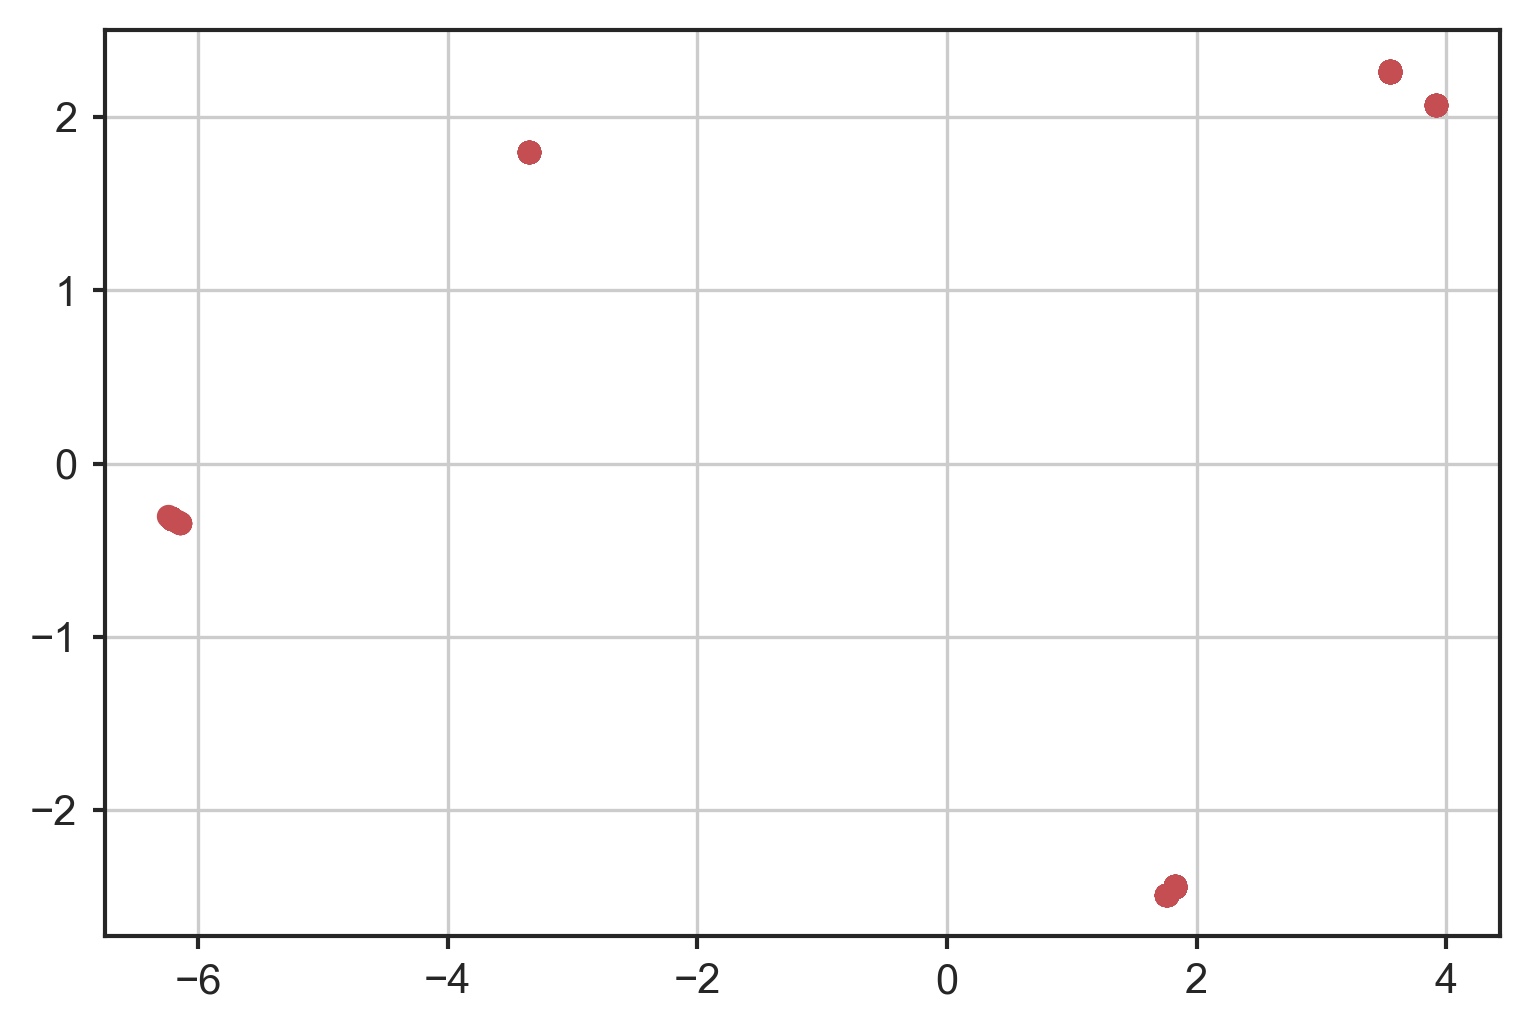

In [44]:
plt.scatter(pos2d[:,0], pos2d[:,1])
plt.show()

Try the same in 3D space

In [34]:
seed = np.random.RandomState(seed=3)

mds = manifold.MDS(
    n_components=3,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="euclidean",
    n_jobs=1,
)

In [35]:
pos3d = mds.fit(states).embedding_
pos3d.shape

(956, 3)

In [36]:
from mpl_toolkits import mplot3d

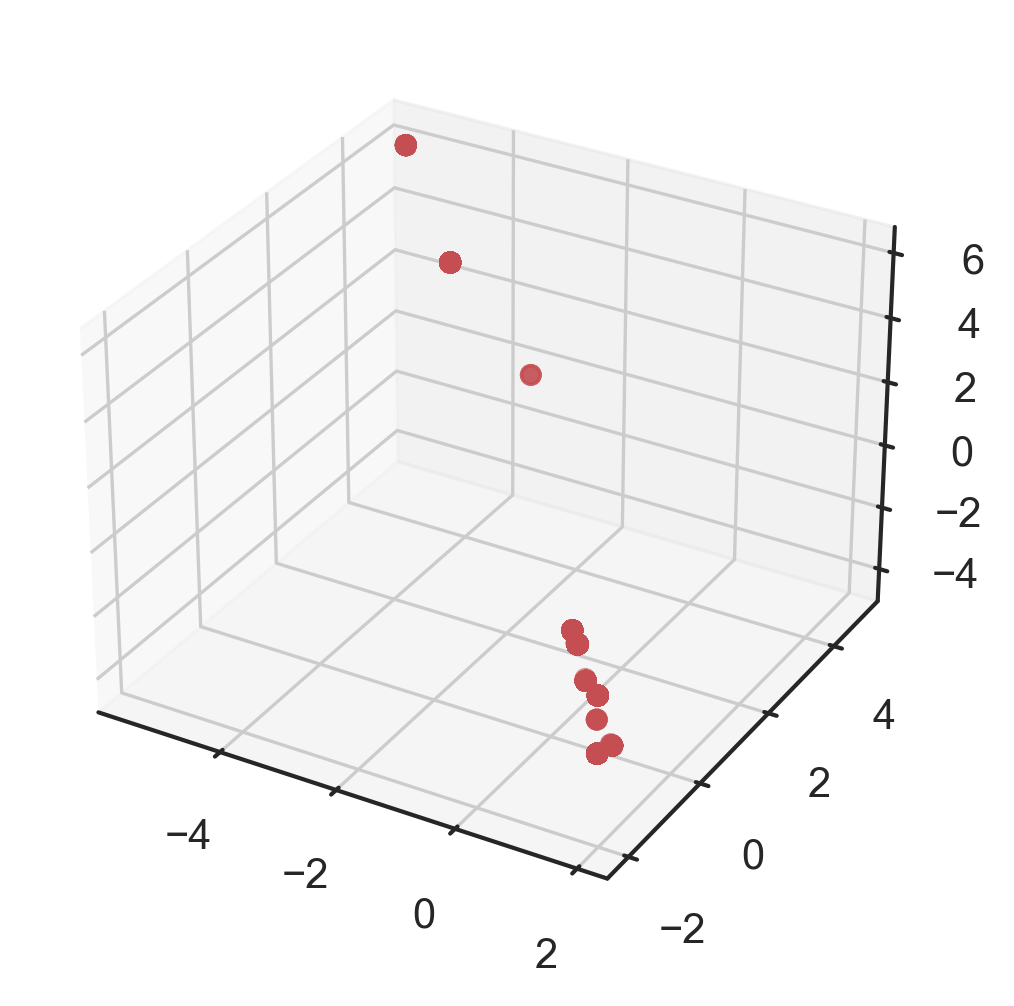

In [37]:
ax = plt.axes(projection='3d')
ax.scatter3D(pos3d[:,0], pos3d[:,1], pos3d[:,2], cmap='Greys');